# **Proyecto Final NLP - Notebook 4**

In [ ]:
%load_ext autoreload
%autoreload 2

! pip install rdkit-pypi

     |████████████████████████████████| 22.3 MB 1.5 MB/s 


# Modelo CNN con generador, embedings de smiles y data-augmentation

In [ ]:
import pandas as pd
import numpy as np
from datagen import smiles_dict, smiles_to_seq

### smiles_dict

In [ ]:
len(smiles_dict)

42

smiles_dict nos da un tokenizador para simplificar el problema. Puede ver como se construyó en la notebook **deep_chem**.
Si al momento de correr el modelo con este diccionario encuentra problemas de key_error, puede agregar los faltantes al diccionario

Mirar dentro de **datagen.py** como se usa este diccionario con la función **smiles_to_seq** para tokenizar. El código es muy sencillo

In [ ]:
print(smiles_dict)

{'#': 1, '(': 2, ')': 3, '+': 4, '-': 5, '/': 6, '1': 7, '2': 8, '3': 9, '4': 10, '5': 11, '6': 12, '7': 13, '8': 14, '=': 15, 'C': 16, 'F': 17, 'H': 18, 'I': 19, 'N': 20, 'O': 21, 'P': 22, 'S': 23, '[': 24, '\\': 25, ']': 26, '_': 27, 'c': 28, 'Cl': 29, 'Br': 30, 'n': 31, 'o': 32, 's': 33, '@': 34, '.': 35, 'a': 36, 'B': 37, 'e': 38, 'i': 39, '9': 40, '10': 41, '11': 42}


# Carga de los datos

In [ ]:
! mkdir data
! mkdir models

df = pd.read_csv('acetylcholinesterase_02_bioactivity_data_preprocessed.csv')

max_len_idx = df['canonical_smiles'].apply(len).argmax()
min_len_idx = df['canonical_smiles'].apply(len).argmin()
max_sequence_len = len(df['canonical_smiles'].iloc[max_len_idx]) + 20

df.head()

X = df['canonical_smiles'].values
y = df['pIC50'].values

mkdir: cannot create directory ‘data’: File exists
mkdir: cannot create directory ‘models’: File exists


# Data augmentation:

https://arxiv.org/pdf/1703.07076.pdf

https://github.com/EBjerrum/molvecgen

https://github.com/Ebjerrum/SMILES-enumeration

En la publicación de arriba se describe una técnica de aumentación de datos para los smiles. Leerla si es de su interes (Opcional)

En el módulo **dataug.py**, tomando como referencia los repositorios arriba citados se implementó la aumentación de datos

In [ ]:
from dataaug import SmilesEnumerator
sme = SmilesEnumerator()
for i in range(10):
    print(sme.randomize_smiles('CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1'))
    

n1n(-c2cc(OCc3ccccc3)ccc2)c(=O)oc1OCC
n1n(-c2cc(OCc3ccccc3)ccc2)c(=O)oc1OCC
CCOc1oc(=O)n(-c2cc(OCc3ccccc3)ccc2)n1
c1(OCc2ccccc2)cc(-n2c(=O)oc(OCC)n2)ccc1
c1(OCc2ccccc2)cc(-n2c(=O)oc(OCC)n2)ccc1
c1c(OCc2ccccc2)cccc1-n1nc(OCC)oc1=O
n1(-c2cc(OCc3ccccc3)ccc2)nc(OCC)oc1=O
c1cccc(COc2cc(-n3c(=O)oc(OCC)n3)ccc2)c1
o1c(=O)n(-c2cccc(OCc3ccccc3)c2)nc1OCC
CCOc1oc(=O)n(-c2cccc(OCc3ccccc3)c2)n1


# DataGenerator

Construir un generador al que se le pase al instanciarlo:
- X: smiles (formula química)
- y: pIC50
- batch_size
- max_sequence_len (int): La máxima longitud de las secuencias (para hacer el padding)
- data_augmentation (boolean): si quiero hacer o no data-augmentation. 
- shuffle (boolean)

Guardarlo en el módulo **datagen.py** con el nombre de la clase **DataGenerator**

Notar que el módulo **datagen.py** ya tiene una estructura para completar

### Importamos el módulo y lo probamos

In [ ]:
from datagen import DataGenerator

dgen = DataGenerator(X, y, max_sequence_len, batch_size=16)
print(len(dgen) * dgen.batch_size)
for i, (X_b, y_b) in enumerate(dgen):
    print(f'{i}\r', end='')

5104


# Split

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
len(X_train), len(y_train), len(X_test)
print(X_train)

dgen_train = DataGenerator(X_train, y_train, seq_length=max_sequence_len, batch_size=128, data_augmentation=True)
dgen_test = DataGenerator(X_test, y_test, seq_length=max_sequence_len, batch_size=128, data_augmentation=False)

for i, (X_b, y_b) in enumerate(dgen_test):
    print(f'{i}\r', end='')

['COc1ccccc1C(=O)Nc1ccc2c(c1)CN(C(=O)c1cccc(Cl)c1)C(=O)C2'
 'c1ccc2oc(CNCCCCCCCNc3c4c(nc5ccccc35)CCCC4)cc2c1'
 'C=C1c2cc(Cl)ccc2N=C2CCCCCN12' ...
 'O=C(Cc1cc(=O)oc2cc(O)ccc12)N/N=C1\\SCC(=O)N1c1c2c(nc3ccccc13)CCCC2'
 'O=C(NCCCCCc1ccccc1)Oc1ccc(-n2cc(COc3ccc4ccc(=O)oc4c3)nn2)cc1'
 'CN(C)Cc1ccc(CSCCCCCCCCSCc2ccc(CN(C)C)o2)o1']


# Network Model

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Bidirectional, Dropout, Activation, BatchNormalization, Conv1D, MaxPool1D, GlobalMaxPooling1D, Flatten
from tensorflow.python.keras.layers.pooling import MaxPooling1D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import backend as K
import tensorflow as tf
from tensorflow.keras import layers as L

# Model_2:

In [ ]:
# Implementar modelo de TextCNN
def text_cnn_1d(sequence_length, vocab_size, embedding_size, filter_sizes, num_filters, dropout):
    # Recordar que estamos en la funcional model API y hay que entender que conectar con que.
    input_x = L.Input(shape=(sequence_length,), name='input_x')
    embedding = Embedding(input_dim= vocab_size, output_dim = embedding_size, input_length=sequence_length)(input_x)
    pooled_outputs = []
    for filter_size in filter_sizes:
        conv = Conv1D(num_filters, kernel_size = filter_size, activation='relu', padding='same')(embedding)
        max_p = MaxPool1D(2, padding = 'same')(conv)

        conv_2 = Conv1D(num_filters*2, kernel_size = filter_size, activation='relu', padding='same')(max_p)
        g_max_p = GlobalMaxPooling1D()(conv_2)

        pooled_outputs.append(g_max_p)
        
    h_pool = L.Concatenate(axis=1)(pooled_outputs)
    dense = L.Flatten()(h_pool)
    dense = Dense(300, activation = 'relu')(dense)
    dense = Dropout(dropout)(dense)
    dense = Dense(150, activation = 'relu')(dense)
    dense = L.Dense(1)(dense) # Salida
    model = tf.keras.models.Model(inputs= input_x, outputs = dense)
    return model

# Puede cambiar estos hiperparámtros. Son solo de referencia
FILTER_SIZES = (3, 4, 5)
NUM_FILTERS = 128
vocab_size = len(smiles_dict)
embeddings_size = 128 # 2
DROPOUT = 0.2

model = text_cnn_1d(max_sequence_len, vocab_size, embeddings_size, FILTER_SIZES, NUM_FILTERS, DROPOUT)
model.summary()

def R2(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=[R2])
mcp = ModelCheckpoint('models/text_cnn_Model2_100epoch_X2_condropout.h5', verbose=1, save_best_only=True, mode='max', monitor='val_R2', save_format="h5")

history = model.fit(dgen_train, epochs=100, validation_data=dgen_test, callbacks=[mcp])

X_test_eval = []
y_t_eval = []
for X_t, y_t in dgen_test:
    X_test_eval = X_test_eval + [list(t) for t in X_t]
    y_t_eval = y_t_eval + list(y_t)
X_test_eval = np.array(X_test_eval)
y_test = np.array(y_t_eval)

X_test_eval.shape, y_test.shape
y_pred = model.predict(X_test_eval)

r2 = 1 - ((y_test - y_pred.reshape(-1)) ** 2).sum() / ((y_test - y_test.mean()) ** 2).sum()
print(r2)

filename = 'models/text_cnn_Model2_100epoch_X2_condropout.h5'
model.save(filename)

from tensorflow.keras.models import load_model

model_loaded = load_model(filename, custom_objects={'R2': R2})
y_pred = model_loaded.predict(X_test_eval)
r2 = 1 - ((y_test - y_pred.reshape(-1)) ** 2).sum() / ((y_test - y_test.mean()) ** 2).sum()
print('R2 test:',r2)


###Model 2:

In [ ]:
# modelo sin dropout, 100 epoch, lr=0,001 
from tensorflow.keras.models import load_model
filename = 'models/text_cnn_Model2_100epoch_X1_sindropout.h5'
model_loaded = load_model(filename, custom_objects={'R2': R2})
y_pred = model_loaded.predict(X_test_eval)
r2 = 1 - ((y_test - y_pred.reshape(-1)) ** 2).sum() / ((y_test - y_test.mean()) ** 2).sum()
print(r2)

0.5754146491582417


### Model 1:

In [ ]:
# modelo con dropout, 100 epoch, lr=0,0001 
filename = 'models/text_cnn_Model2_100epoch_X2_condropout.h5'
model_loaded = load_model(filename, custom_objects={'R2': R2})
y_pred = model_loaded.predict(X_test_eval)
r2 = 1 - ((y_test - y_pred.reshape(-1)) ** 2).sum() / ((y_test - y_test.mean()) ** 2).sum()
print(r2)

0.5664935361914898


# Evaluación

<function matplotlib.pyplot.show>

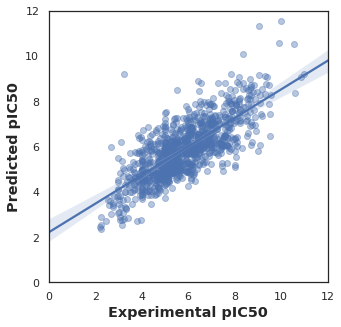

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(color_codes=True)
sns.set_style("white")

ax = sns.regplot(x=y_test, y=y_pred, scatter_kws={'alpha':0.4})
ax.set_xlabel('Experimental pIC50', fontsize='large', fontweight='bold')
ax.set_ylabel('Predicted pIC50', fontsize='large', fontweight='bold')
ax.set_xlim(0, 12)
ax.set_ylim(0, 12)
ax.figure.set_size_inches(5, 5)
plt.show

# Bibliografia:

[MaxPool1D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool1D)

[MaxPooling1D](https://keras.io/api/layers/pooling_layers/max_pooling1d/)

[GlobanAverigePooling1D-keras](https://keras.io/api/layers/pooling_layers/global_average_pooling1d/)

[GlobanAverigePooling1D-tf](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling1D)

[Diference Between ap & gap](https://stackoverflow.com/questions/54493738/keras-difference-between-averagepooling1d-layer-and-globalaveragepooling1d-laye)

[Filter & Kernel Size: Towards Data Science](https://towardsdatascience.com/deciding-optimal-filter-size-for-cnns-d6f7b56f9363)

[Filter & Kernel Size: Quora](https://www.quora.com/What-is-the-meaning-of-a-filter-size-in-a-CNN)

[Filter & Kernel Size: Medium](https://medium.com/analytics-vidhya/how-to-choose-the-size-of-the-convolution-filter-or-kernel-size-for-cnn-86a55a1e2d15)

[Filter & Kernel Size: Stack Exchange](https://stats.stackexchange.com/questions/154798/difference-between-kernel-and-filter-in-cnn)

[CNN - cs231n](https://cs231n.github.io/convolutional-networks/)

[CNN1D - machinelearningmastery](https://machinelearningmastery.com/cnn-models-for-human-activity-recognition-time-series-classification/)

[CNN1D - stackoverflow](https://stackoverflow.com/questions/66220774/difference-between-the-input-shape-for-a-1d-cnn-2d-cnn-and-3d-cnn)

[CNN1D - keras](https://keras.io/api/layers/convolution_layers/convolution1d/)

[TextCnn1D - PyTorch example GitHub](https://github.com/Renovamen/Text-Classification/blob/master/models/TextCNN/cnn1d.py)

